In [1]:
!pip install torch torchvision torchaudio
!pip install ultralytics
!pip install clearml

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [3]:
import requests
import os
import zipfile

# Function to download file from Dropbox
def download_file(url, save_name):
    if not os.path.exists(save_name):
        # Modify the URL to make it a direct download link
        direct_download_url = url.replace("dl=0", "dl=1")
        file = requests.get(direct_download_url)
        open(save_name, 'wb').write(file.content)

# Download the file from Dropbox
dropbox_url = 'https://www.dropbox.com/scl/fi/fsljj97eyniohackasvi5/Traffic-Light-Detection.v2i.yolov8.zip?rlkey=b0ad41cmso07r2s0lorzobjuf&st=bedw8isl&dl=0'
save_name = '/content/traffic_dataset_v8.zip'
download_file(dropbox_url, save_name)

# Function to unzip the downloaded file
def unzip(zip_file):
    try:
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall('/content/datasets')
        print("Extraction successful.")
    except Exception as e:
        print(f"Error extracting '{zip_file}': {str(e)}")

# Unzip the downloaded file
unzip(save_name)


Extraction successful.


In [4]:
%cd ..

/


In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

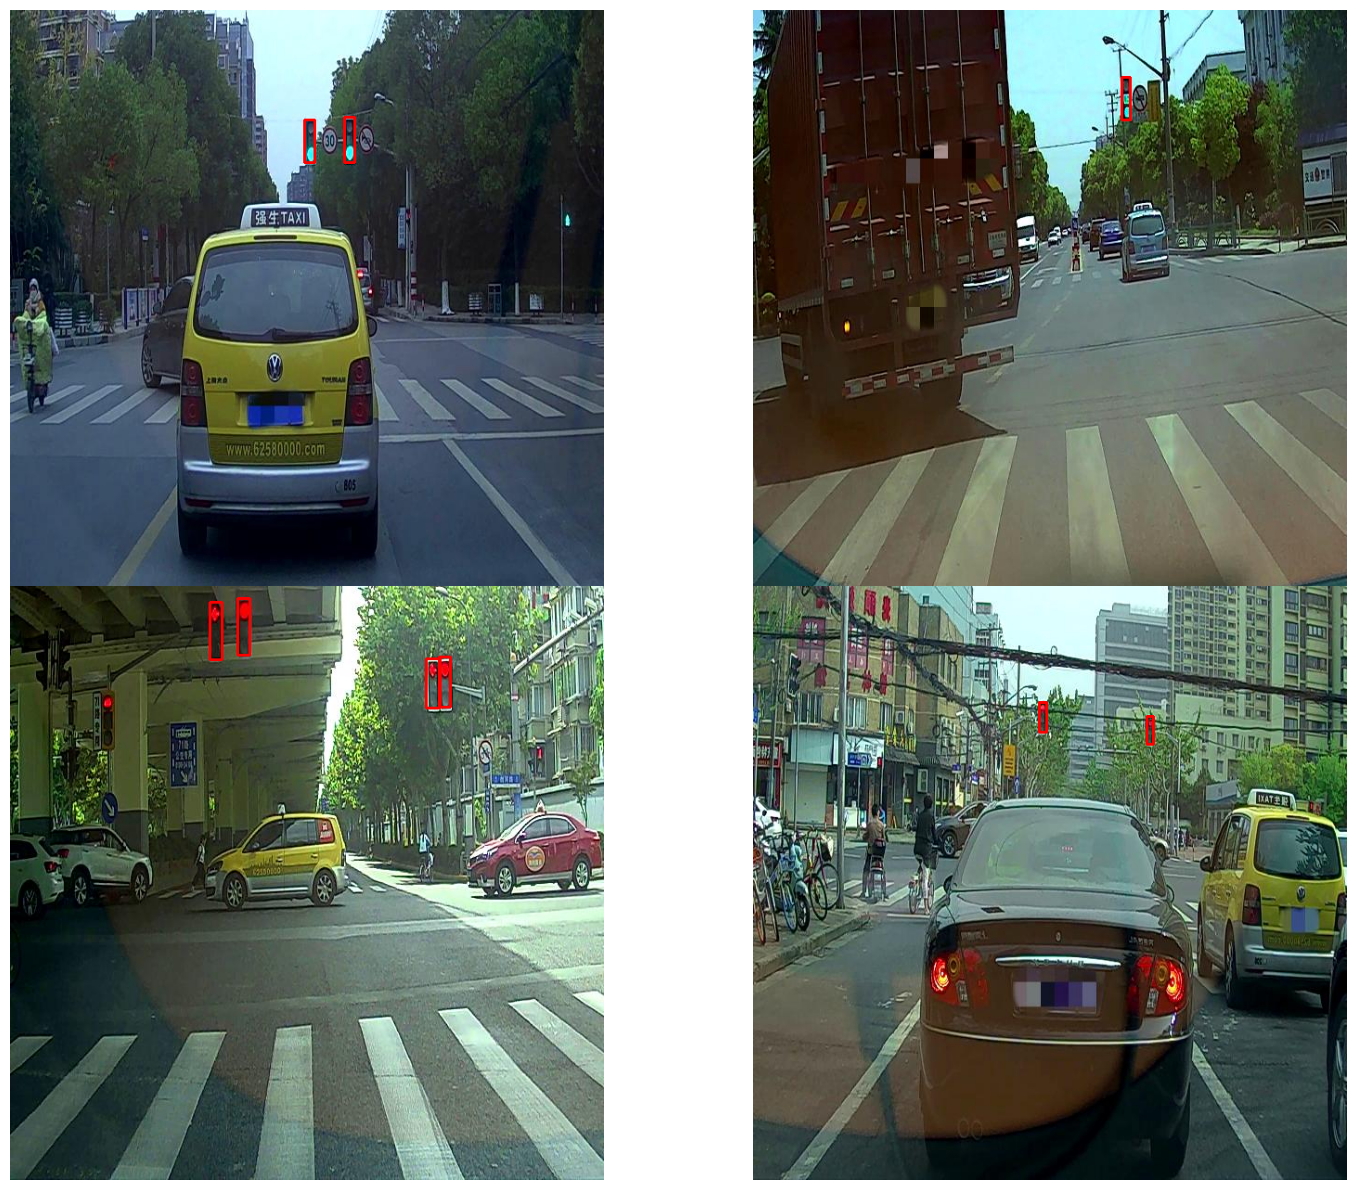

In [8]:
# Visualize a few training images.
plot(
    image_paths='/content/datasets/train/images/',
    label_paths='/content/datasets/train/labels/',
    num_samples=4,
)

In [9]:

# Define paths to your dataset directories
train_path = '/content/datasets/train'
val_path = '/content/datasets/valid'
test_path = '/content/datasets/test'

# Define the content of your dataset.yaml file
yaml_content = f"""
train: {train_path}
val: {val_path}
test: {test_path}
nc: 4
names: ['green', 'off', 'red', 'yellow']
"""

# Write the YAML content to a file named dataset.yaml
with open('/content/dataset.yaml', 'w') as f:
    f.write(yaml_content)

# Verify the content of dataset.yaml
!cat /content/dataset.yaml



train: /content/datasets/train
val: /content/datasets/valid
test: /content/datasets/test
nc: 4
names: ['green', 'off', 'red', 'yellow']


In [10]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data='/content/dataset.yaml' epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

100% 6.25M/6.25M [00:00<00:00, 78.1MB/s]
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

In [11]:
import os

# Directory where the weights should be saved
weights_dir = 'runs/detect/yolov8n_custom/weights'

# Check if the directory exists
if os.path.exists(weights_dir):
    # List the files in the directory
    files = os.listdir(weights_dir)
    print(f"Files in {weights_dir}: {files}")
else:
    print(f"Directory not found: {weights_dir}")


Directory not found: runs/detect/yolov8n_custom/weights


In [18]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt data=/content/dataset.yaml imgsz=1280


Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 931 images, 0 backgrounds, 0 corrupt: 100% 931/931 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 59/59 [00:31<00:00,  1.85it/s]
                   all        931       2379      0.895      0.931      0.946      0.623
                 green        487        953      0.898      0.962      0.977      0.653
                   off         72        114      0.875       0.86      0.936      0.564
                   red        594       1283      0.936       0.98      0.984      0.673
                yellow         17         29       0.87      0.924      0.886      0.601
Speed: 3.9ms preprocess, 14.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://

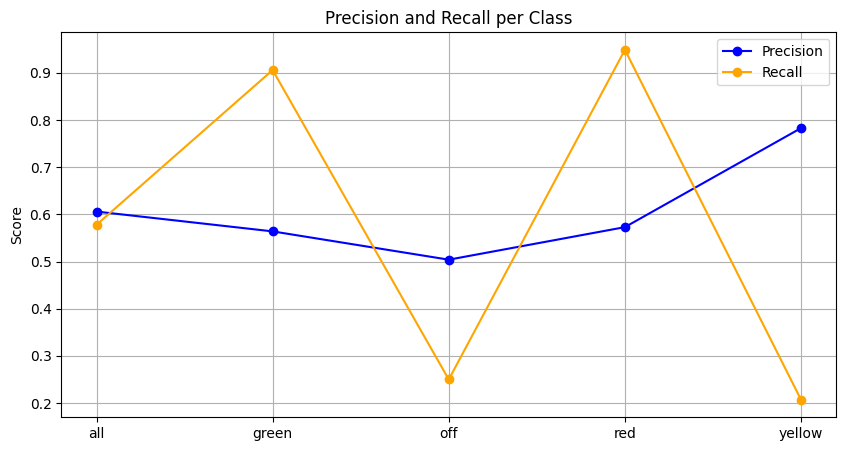

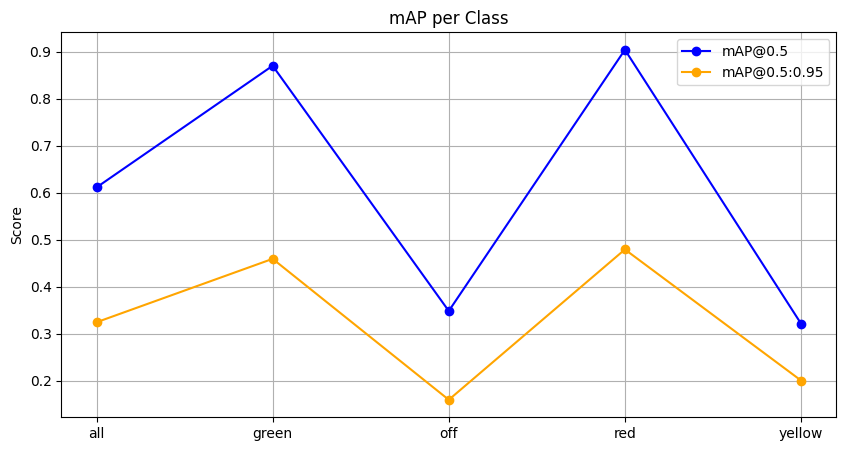

In [19]:
import matplotlib.pyplot as plt

# Define the metrics from your output
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Plot Precision and Recall
plt.figure(figsize=(10, 5))
plt.plot(classes, precision, marker='o', label='Precision', color='blue')
plt.plot(classes, recall, marker='o', label='Recall', color='orange')
plt.title('Precision and Recall per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP
plt.figure(figsize=(10, 5))
plt.plot(classes, map50, marker='o', label='mAP@0.5', color='blue')
plt.plot(classes, map50_95, marker='o', label='mAP@0.5:0.95', color='orange')
plt.title('mAP per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


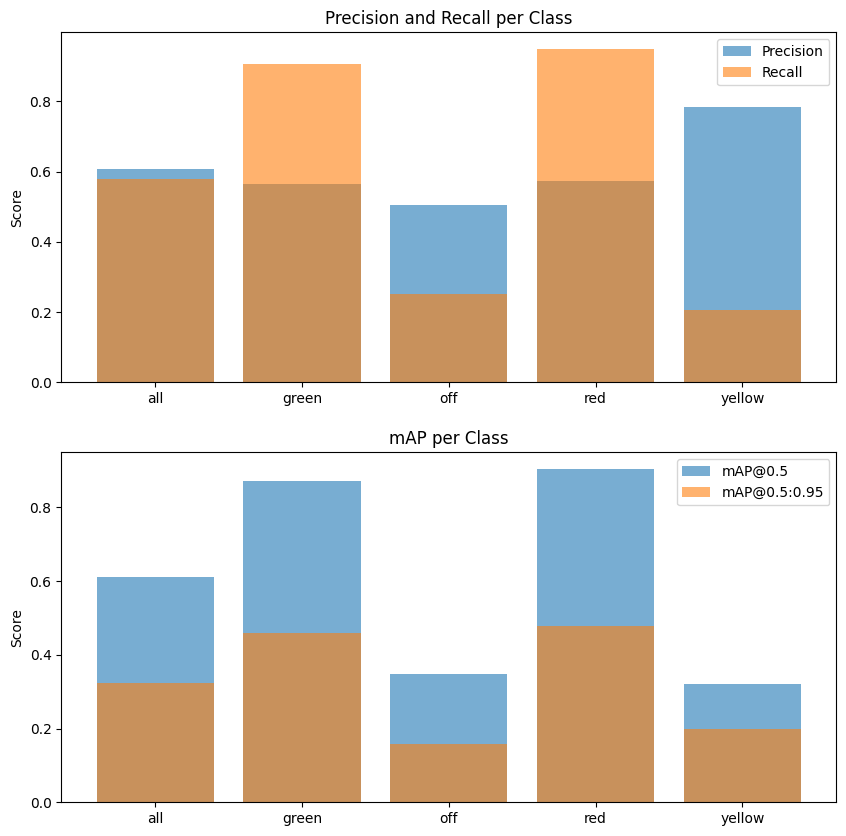

In [20]:
import matplotlib.pyplot as plt

# Metrics for each class
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Precision and Recall
ax[0].bar(classes, precision, alpha=0.6, label='Precision')
ax[0].bar(classes, recall, alpha=0.6, label='Recall')
ax[0].set_title('Precision and Recall per Class')
ax[0].set_ylabel('Score')
ax[0].legend()

# mAP
ax[1].bar(classes, map50, alpha=0.6, label='mAP@0.5')
ax[1].bar(classes, map50_95, alpha=0.6, label='mAP@0.5:0.95')
ax[1].set_title('mAP per Class')
ax[1].set_ylabel('Score')
ax[1].legend()

plt.show()


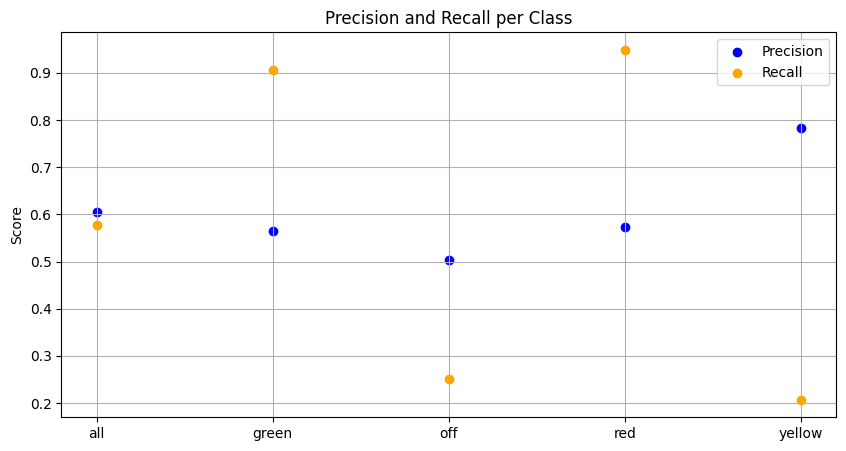

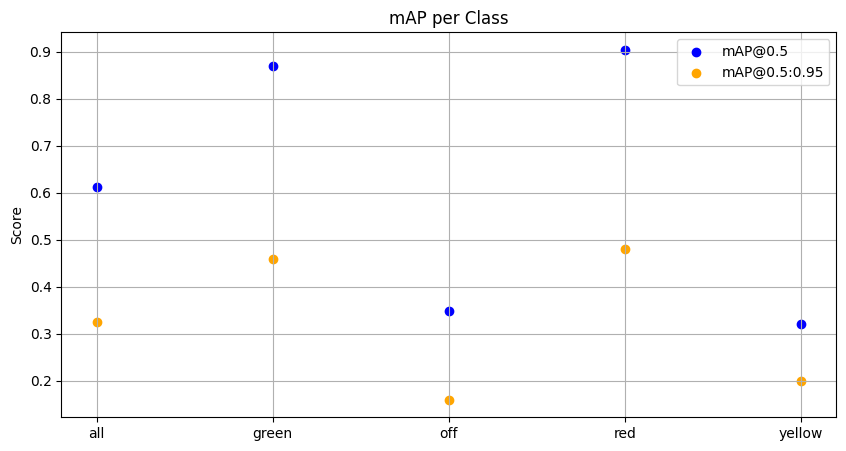

In [21]:
import matplotlib.pyplot as plt

# Define the metrics from your output
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Plot Precision and Recall
plt.figure(figsize=(10, 5))
plt.scatter(classes, precision, label='Precision', color='blue')
plt.scatter(classes, recall, label='Recall', color='orange')
plt.title('Precision and Recall per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP
plt.figure(figsize=(10, 5))
plt.scatter(classes, map50, label='mAP@0.5', color='blue')
plt.scatter(classes, map50_95, label='mAP@0.5:0.95', color='orange')
plt.title('mAP per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


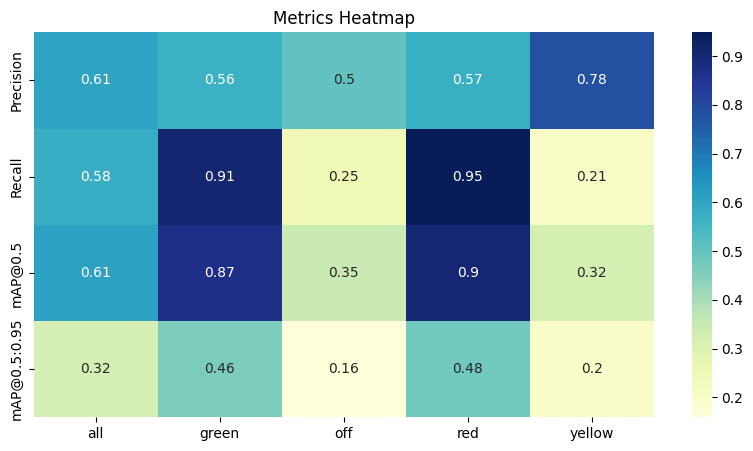

In [22]:
import seaborn as sns
import numpy as np

# Define the metrics from your output
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Create a matrix of metrics
metrics = np.array([precision, recall, map50, map50_95])

# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(metrics, annot=True, cmap="YlGnBu", xticklabels=classes, yticklabels=['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95'])
plt.title('Metrics Heatmap')
plt.show()
